In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

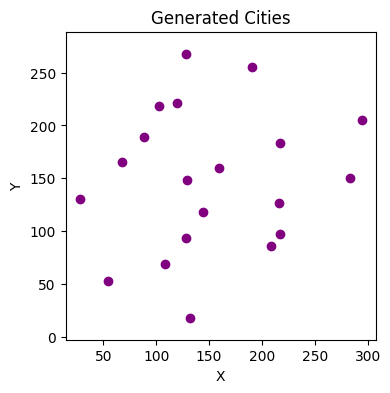

In [2]:
cities = 20

#losowe współrzędne w kwadracie 300x300
SEED = 123
np.random.seed(SEED)
random.seed(SEED)
city = np.random.uniform(0, 300, size=(cities, 2))

plt.figure(figsize=(4,4))
plt.scatter(city[:,0], city[:,1], c='purple')
plt.title("Generated Cities")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

In [3]:
#Macierz odległości -> euklides
euclid = np.sqrt(
    (city[:,0][:,None] - city[:,0][None,:])**2 +
    (city[:,1][:,None] - city[:,1][None,:])**2
)

In [4]:
#Calkowita dlugosc trasy
def total_route(route):
    sum = 0.0
    leg = len(route)
    for i in range(leg):
        j = (i+1)%leg
        sum += euclid[route[i],route[j]]
    return sum

x = 10
test = list(range(x))
print(f"Length of the route for {x} cities equals", total_route(test))

Length of the route for 10 cities equals 1534.2753778959993


In [5]:
#Tworzenie populacji
def create_population(n_population, n_cities):
    random_population = []
    number = list(range(n_cities))
    for _ in range(n_population):
        population = number.copy()
        random.shuffle(population)
        random_population.append(population)
    return random_population

population = create_population(10,5)
print("Example of 3 individuals", population[:3])

Example of 3 individuals [[3, 1, 4, 2, 0], [4, 1, 3, 0, 2], [3, 0, 1, 2, 4]]


In [6]:
#Szukanie najkrotszych tras
def tournament(population, min_route, tournaments):
    range_pop = range(len(population))
    rivals = random.sample(list(range_pop), tournaments)
    best = min(rivals, key=lambda idx: min_route[idx])
    return population[best]

In [7]:
#Krzyzowanie
def crossing(parent1, parent2):
    size = len(parent1)
    a, b = sorted(random.sample(range(size), 2))
    child = [-1]*size #niewypelnione jeszcze dziecko

    #wylosowany fragment do dziecka
    child[a:b+1] = parent1[a:b+1]

    #reszte wstawic pomijajac wypelnione
    counter = 0
    for i in range(size):
        if child[i]==-1: #tylko w puste miejsca
            while parent2[counter] in child:
                counter+=1
            child[i] = parent2[counter]
    return child

In [8]:
#Mutacja
mutation_prop = 0.05
def mutation(trip, probability=mutation_prop):
    copy_trip = trip.copy()
    if random.random()<probability:
        i,j = random.sample(range(len(copy_trip)), 2)
        copy_trip[i], copy_trip[j] = copy_trip[j], copy_trip[i] #zamieniamy miejscami wylosowane pozycje
    return copy_trip

In [9]:
def run(num_cities, populations, generations, cross_prop, mutation_prop, tournaments, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    population = create_population(populations, num_cities)
    best_result = []
    mean_result = []
    global_best = None
    global_best_cost = float('inf')

    for _ in range(generations):
        route_length = [total_route(route) for route in population]
        # lokalny najlepszy
        local_best_idx = int(np.argmin(route_length))
        local_best_cost = route_length[local_best_idx]

        # aktualizacja globalnego najlepszego
        if local_best_cost < global_best_cost:
            global_best_cost = local_best_cost
            global_best = population[local_best_idx].copy()

        best_result.append(local_best_cost)
        mean_result.append(sum(route_length)/len(route_length))
        
        #nastepna populacja
        new_population = []
        while len(new_population)<populations:
            #selekcja rodziców
            parent1 = tournament(population, route_length, tournaments)
            parent2 = tournament(population, route_length, tournaments)

            #krzyzowanie
            if random.random() < cross_prop:
                child1 = crossing(parent1, parent2)
                child2 = crossing(parent2, parent1)
            else:
                child1, child2 = parent1.copy(), parent2.copy()

            #mutacja
            child1 = mutation(child1, mutation_prop)
            child2 = mutation(child2, mutation_prop)
            
            new_population.extend([child1, child2])
            
        population = new_population[:populations]
    return best_result, mean_result, population

#Parametry
populations = 100
generations = 200
cross_prop = 0.9
mutation_prop = 0.05
tournaments = 3
cities = 20

best_result, mean_result, final_population = run(
    num_cities=cities,
    populations=populations,
    generations=generations,
    cross_prop=cross_prop,
    mutation_prop=mutation_prop,
    tournaments=tournaments,
    seed=SEED
)

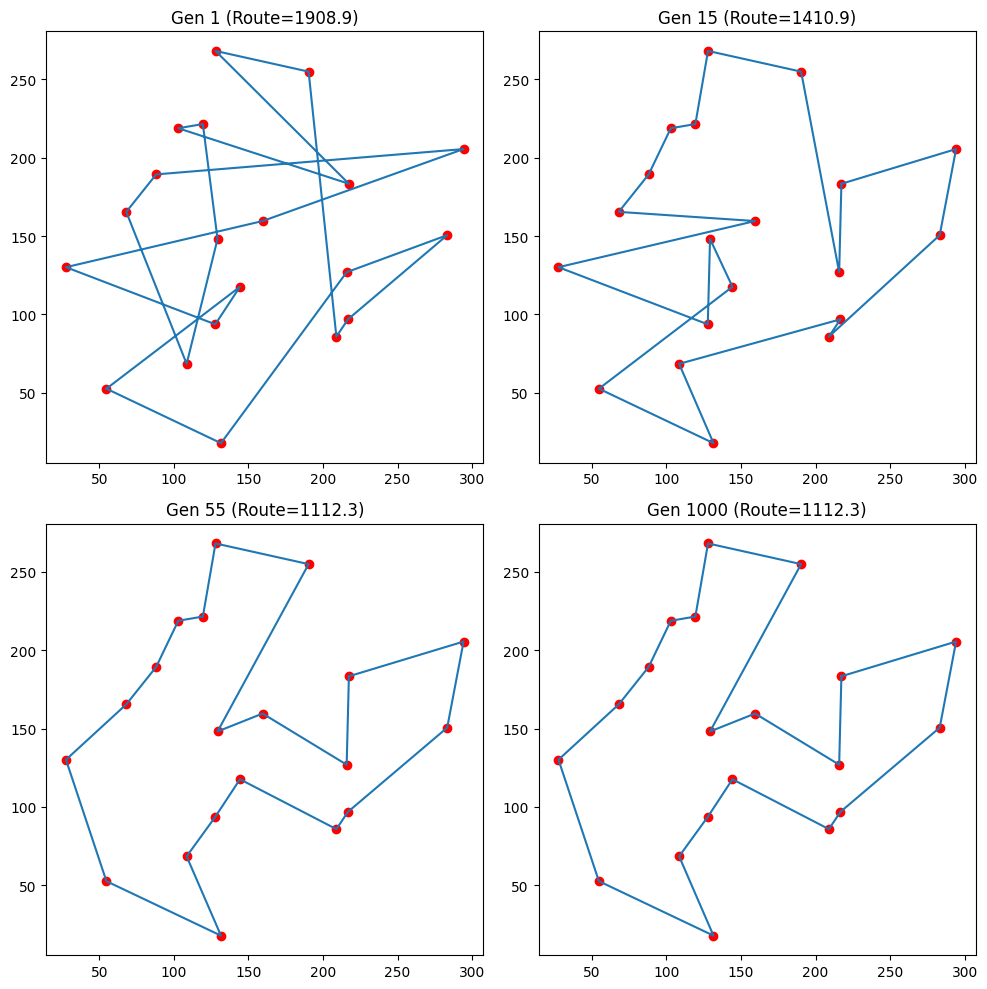

In [14]:
#Jak algorytm uczyl sie:
gens = [1, 15, 55, generations]
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for ax, g in zip(axes.flatten(), gens):
    #dla pokolenia g
    best_result, mean_result, pop_g= run(
        num_cities=cities,
        populations=populations,
        generations=g,
        cross_prop=cross_prop,
        mutation_prop=mutation_prop,
        tournaments=tournaments,
        seed=SEED
    )
    #weź najlepszą trasę z ostatniej populacji
    fits = [total_route(r) for r in pop_g]
    route = pop_g[int(np.argmin(fits))]
    loop = route + [route[0]]
    coords = city[loop]
    
    #narysuj miasta i trasę
    ax.scatter(city[:,0], city[:,1], c='red')
    ax.plot(coords[:,0], coords[:,1], '-')
    length = total_route(route)
    ax.set_title(f"Gen {g} (Route={length:.1f})")
plt.tight_layout()
plt.show()


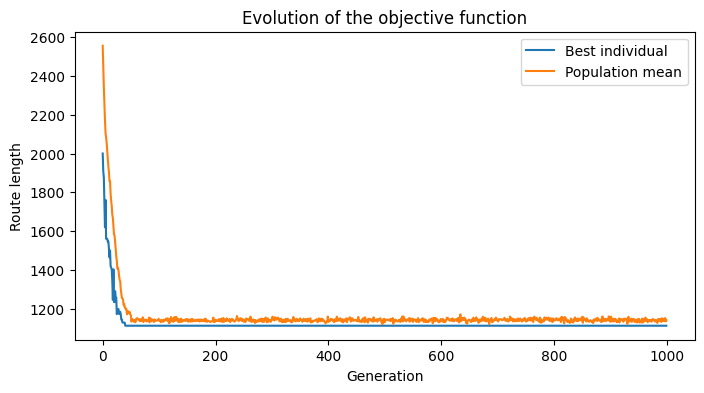

In [15]:
plt.figure(figsize=(8,4))
plt.plot(best_result, label="Best individual")
plt.plot(mean_result, label="Population mean")
plt.xlabel("Generation")
plt.ylabel("Route length")
plt.legend()
plt.title("Evolution of the objective function")
plt.show()

Na wykresie widać, że algorytm genetyczny bardzo szybko obniża długość trasy w pierwszych kilkudziesięciu pokoleniach, a potem praktycznie przestaje się zmieniać – osiąga dobre rozwiązanie i tylko delikatnie je poprawia. Średnia długość tras w populacji zawsze jest większa od długości najlepszej trasy, bo trafia się wiele gorszych rozwiązań, ale ogólnie całość stabilizuje się wokół optymalnego minimum już po około 30–40 generacjach.


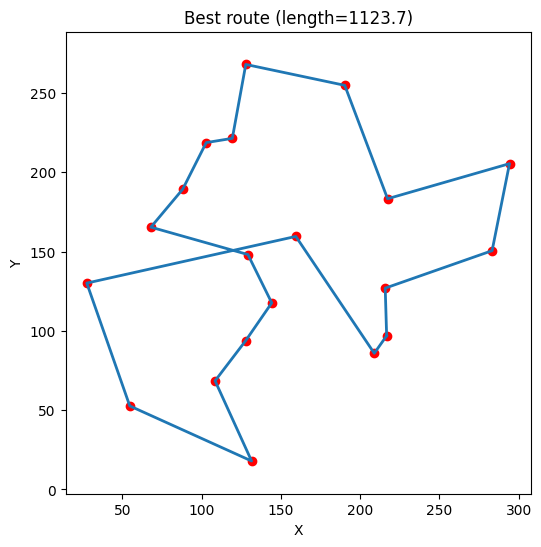

In [12]:
#Najlepsza trasa
final = [total_route(route) for route in final_population]
num_best = int(np.argmin(final))
best_route = final_population[num_best]

#Miasta i trasa
plt.figure(figsize=(6,6))
plt.scatter(city[:,0], city[:,1], c='red')

#Na koniec listy pierwsze miasto
loop = best_route+[best_route[0]]
coords = city[loop]

plt.plot(coords[:,0], coords[:,1], '-', linewidth=2)
plt.title(f"Best route (length={final[num_best]:.1f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

Na wykresie widzimy, że algorytm ułożył spójną pętlę łączącą wszystkie miasta i zamyka ją w punkcie startowym. Trasa omija niepotrzebne „skoki” przez cały obszar i prowadzi w miarę logicznej kolejności, co minimalizuje długość. Uzyskana wartość ~1200 jest rozsądna jak na prostą wersję GA na 20 miast w kwadracie 300×300. To potwierdza, że algorytm skutecznie optymalizuje problem komiwojażera – jeśli zależy nam na jeszcze lepszym wyniku, można zwiększyć rozmiar populacji, prawdopodobieństwo mutacji lub liczbę pokoleń.

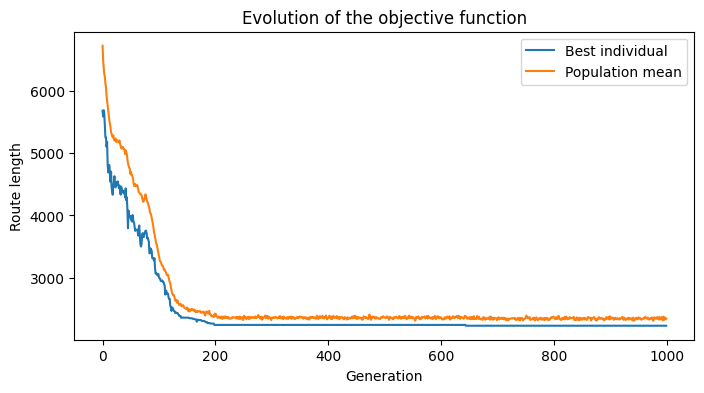

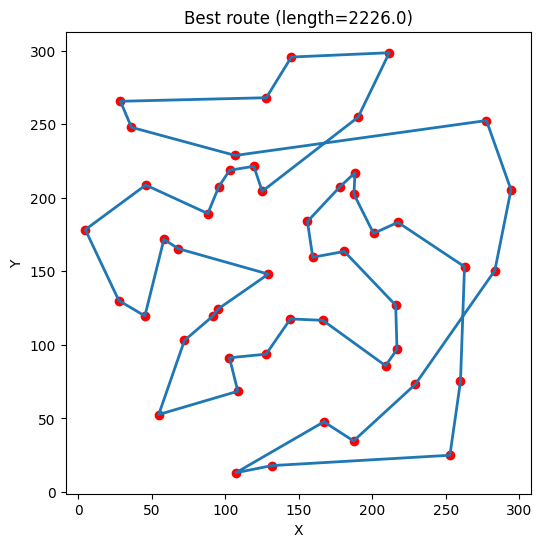

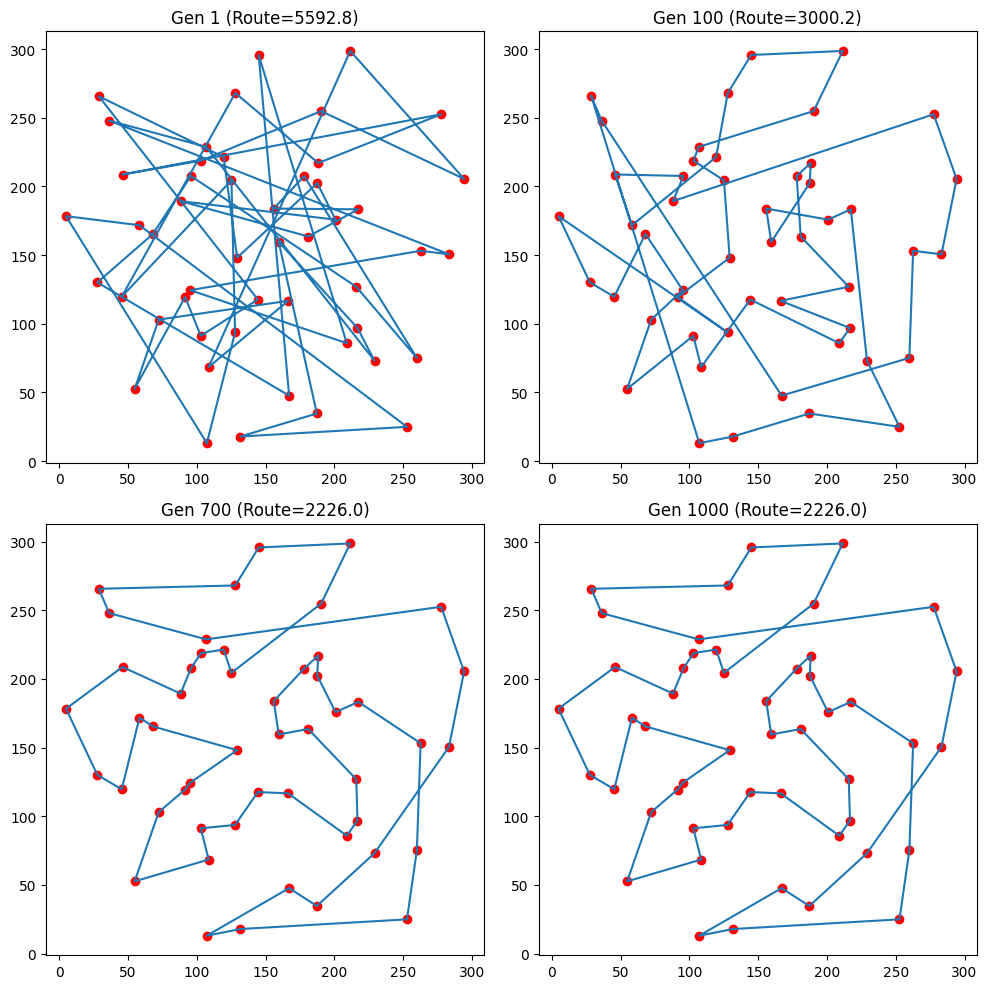

In [16]:
#Nowe parametry
populations = 200
generations = 1000
cross_prop = 0.9
mutation_prop = 0.3
cities2 = 50

#nowa macierz dlugosci
np.random.seed(SEED)
random.seed(SEED)
city2 = np.random.uniform(0, 300, size=(cities2, 2))
euclid = np.sqrt(
    (city2[:,0][:,None] - city2[:,0][None,:])**2 +
    (city2[:,1][:,None] - city2[:,1][None,:])**2
)

best_result, mean_result, final_population = run(
    num_cities=cities2,
    populations=populations,
    generations=generations,
    cross_prop=cross_prop,
    mutation_prop=mutation_prop,
    tournaments=tournaments,
    seed=SEED
)

plt.figure(figsize=(8,4))
plt.plot(best_result, label="Best individual")
plt.plot(mean_result, label="Population mean")
plt.xlabel("Generation")
plt.ylabel("Route length")
plt.legend()
plt.title("Evolution of the objective function")
plt.show()

final = [total_route(route) for route in final_population]
num_best = int(np.argmin(final))
best_route = final_population[num_best]

plt.figure(figsize=(6,6))
plt.scatter(city2[:,0], city2[:,1], c='red')
loop = best_route + [best_route[0]]
coords2 = city2[loop]
plt.plot(coords2[:,0], coords2[:,1], '-', linewidth=2)
plt.title(f"Best route (length={final[num_best]:.1f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()


#Porównanie najlepszych tras w kilku pokoleniach
gens = [1, 100, 700, generations]
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for ax, g in zip(axes.flatten(), gens):
    #uruchom dla pokolenia g
    best_result, mean_result, pop_g= run(
        num_cities=cities2,
        populations=populations,
        generations=g,
        cross_prop=cross_prop,
        mutation_prop=mutation_prop,
        tournaments=tournaments,
        seed=SEED
    )
    #weź najlepszą trasę z ostatniej populacji
    fits = [total_route(r) for r in pop_g]
    route = pop_g[int(np.argmin(fits))]
    loop = route + [route[0]]
    coords2 = city2[loop]
    
    # narysuj miasta i trasę
    ax.scatter(city2[:,0], city2[:,1], c='red')
    ax.plot(coords2[:,0], coords2[:,1], '-')
    length = total_route(route)
    ax.set_title(f"Gen {g} (Route={length:.1f})")
plt.tight_layout()
plt.show()

Przy tak zmienionych parametrach widać, że algorytm szybko uczy się znajdować sensowne trasy nawet dla 50 miast – wstępny spadek kosztu jest naprawdę duży, bo w pierwszych 200–300 generacjach skróciliśmy drogę z ~8000 do ~2300. Potem następuje faza stabilizacji: przez kolejne kilkaset rund poprawki są już bardzo drobne. To pokazuje, że metodą prób i błędów (czyli mutacje i krzyżowania) szybko eliminuje najgorsze fragmenty trasy, a później skupia się na dopracowywaniu detali. Wybierając większy turniej selekcyjny (10 osób), mocniej promujemy najlepsze trasy, co przyspiesza zbieżność, ale zmniejsza różnorodność – dlatego po jakimś czasie algorytm może „utknąć” w lokalnym minimum. Końcowy wynik ~2300 to dobry kompromis między szybkością działania a jakością. Gdybyśmy chcieli jeszcze poprawić efekt, można by np. zmniejszyć rozmiar turnieju lub czasami zwiększyć mutacje, żeby szukać nowych rozwiązań i wydostać się z ewentualnych „pułapek lokalnych”.